## Exploratory Data Analysis on UFO Data

In [203]:
import pandas as pd
import numpy as np 
from numpy import array
import os
import warnings 
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [28]:
from jdcal import gcal2jd, jd2gcal
from timezonefinder import TimezoneFinder
from datetime import datetime
import pytz

In [257]:
import astropy.time
import dateutil.parser

In [138]:
from sklearn.cluster import KMeans

Reading Data: 

In [292]:
cwd = os.getcwd() 
data = pd.read_csv(cwd + "/ufo.csv", error_bad_lines=False, warn_bad_lines = False)
data['datetime2'] = pd.to_datetime(data['datetime'], format = '%m/%d/%Y %H:%M', errors = 'coerce')
data = data[data['datetime2'] >= '01/01/2000']  

In [293]:
list(data) 
print(len(data))

70123


In [230]:
data.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,datetime2
101,10/10/2000 03:00,perryville,mo,us,oval,180,3 minutes,The craft was big&#44 orange&#44 and oval shaped.,12/2/2000,37.7241667,-89.861111,2000-10-10 03:00:00
102,10/10/2000 03:45,carnival cruise ship (paradise) (caribbean),NaN,NaN,flash,1200,20 mins.,Motionless eratic flashing light.,12/9/2000,0,0.000000,2000-10-10 03:45:00
103,10/10/2000 06:15,boynton beach,fl,us,other,10,10 seconds,Unusual light formation moving extremely fast ...,12/2/2000,26.5250000,-80.066667,2000-10-10 06:15:00
104,10/10/2000 07:30,victoria (canada),bc,ca,cylinder,30,30seconds,Smooth Shiny Cylinder,12/2/2000,46.216667,-63.483333,2000-10-10 07:30:00
105,10/10/2000 16:00,jueanu,wi,NaN,triangle,45,45 seconds,5 bight light V shaped,12/2/2000,43.40555,-88.705104,2000-10-10 16:00:00


In [208]:
print("Date Range: {} to {}".format(data['datetime'].min(), data['datetime'].max()))
print("Number of rows: ", len(data))

Date Range: 2000-01-01 00:01:00 to 2014-05-08 18:45:00
Number of rows:  70123


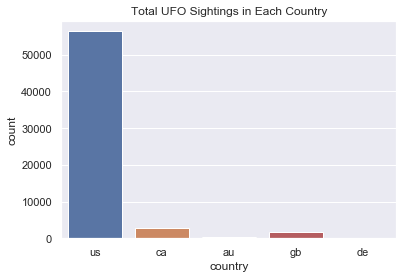

In [209]:
sns.set(style="darkgrid")
ax = sns.countplot(data['country'])
ax.set_title("Total UFO Sightings in Each Country")
plt.show() 

Clearly, America has reported the most UFO sightings - no surprises there! 

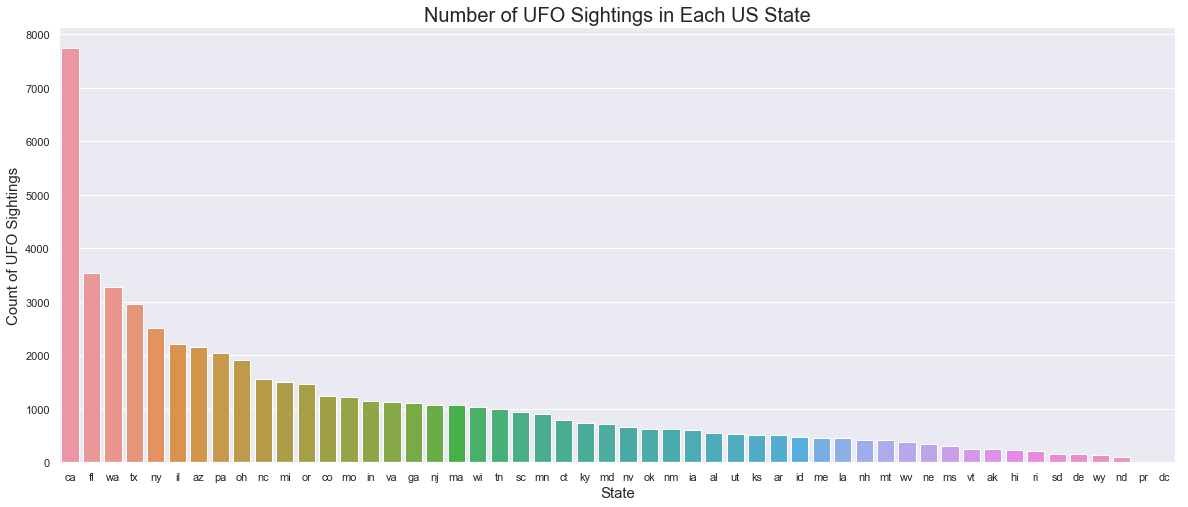

In [210]:
plt.figure(figsize = (20, 8))
us_sightings = data.loc[data['country'] == 'us']
ax =  sns.countplot(us_sightings['state'], order = us_sightings['state'].value_counts().index)
ax.set_title("Number of UFO Sightings in Each US State", fontsize = 20)
ax.set_xlabel("State", fontsize = 15)
ax.set_ylabel("Count of UFO Sightings", fontsize = 15)
plt.show()

By just analysing the US states, we can see that California has reported a lot more sightings compared to the other states.

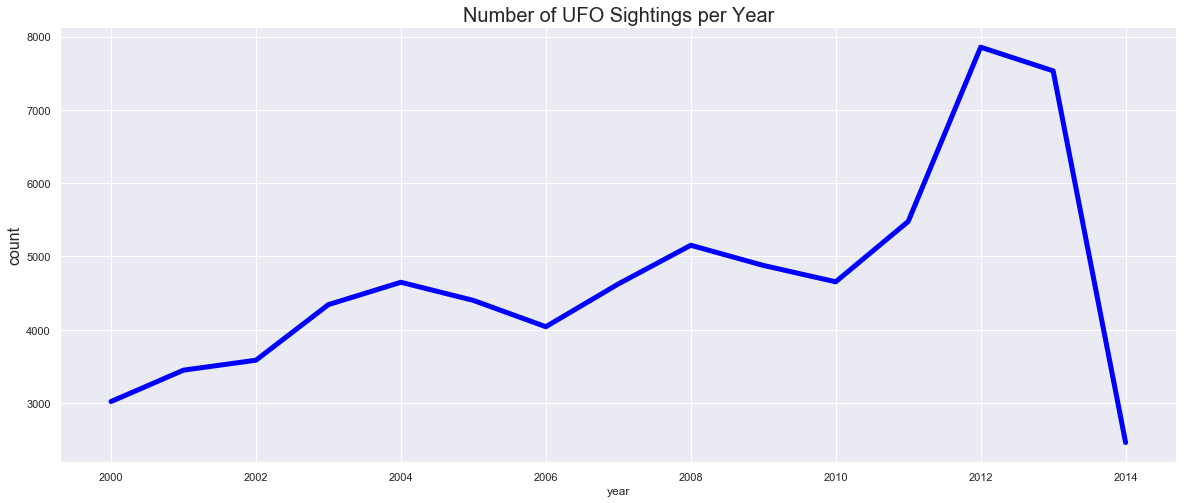

In [256]:
#data['datetime'] = pd.to_datetime(data['datetime'], format = '%m/%d/%Y %H:%M', errors = 'coerce')
plt.figure(figsize = (20, 8))
year_counts = data['datetime2'].groupby([data['datetime2'].dt.year]).agg('count')
ax = year_counts.plot(linewidth = 5, color = "blue")
ax.set_title("Number of UFO Sightings per Year", fontsize = 20)
ax.set_ylabel("count", fontsize = 16)
ax.set_xlabel("year")
plt.show()

In [212]:
print("Number of sightings in 2012:", year_counts.max())

Number of sightings in 2012: 7857


UFO recordings peaked during 2012. Perhaps this is due to the 2012 phenomenon https://en.wikipedia.org/wiki/2012_phenomenon

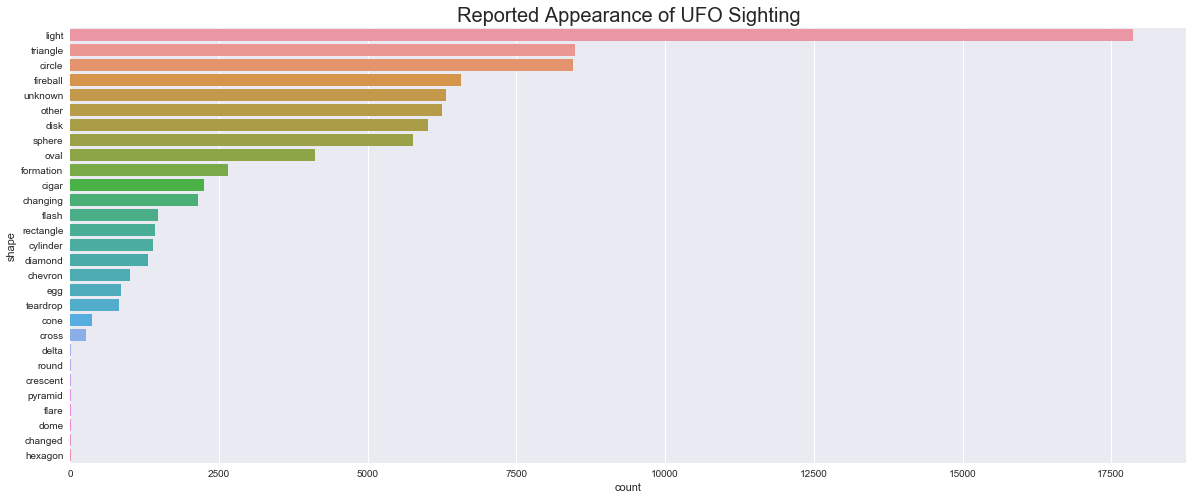

In [9]:
plt.figure(figsize = (20, 8))
ax = sns.countplot(y = data['shape'], order = data['shape'].value_counts().index)
ax.set_title("Reported Appearance of UFO Sighting", fontsize = 20)
plt.show() 

Out of all the UFO sightings, the most common description used to describe the appearance of the UFO was bright light.

In [216]:
duration = pd.to_numeric(data['duration (seconds)'], errors = 'coerce')
data['duration (seconds)'] = duration
reasonable_duration = data.loc[data['duration (seconds)'] < 604800] 
reasonable_duration = reasonable_duration[reasonable_duration['duration (seconds)'] > 0]
print("Average length of UFO sighting (in mins):", np.mean(reasonable_duration['duration (seconds)'])/60)
print("Max length of UFO sighting (in mins):", np.max(reasonable_duration['duration (seconds)'])/60)

Average length of UFO sighting (in mins): 19.197646532367816
Max length of UFO sighting (in mins): 7200.0


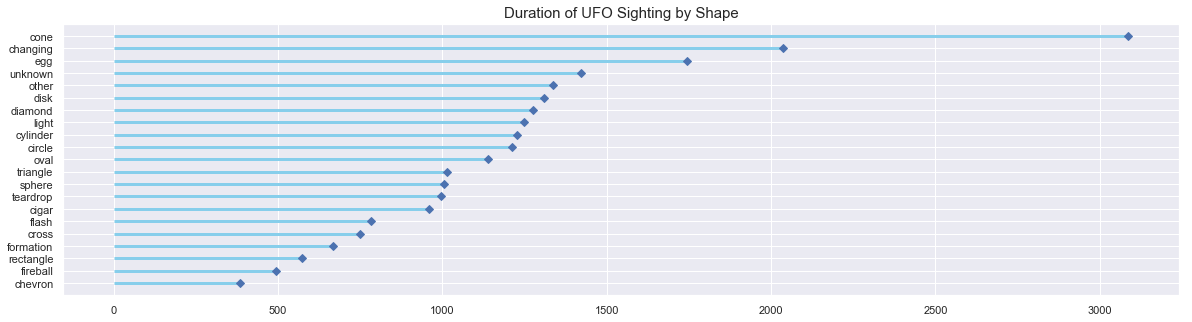

In [217]:
shape_duration_avg = reasonable_duration['duration (seconds)'].groupby(reasonable_duration['shape']).agg('mean')
my_range=range(1,len(shape_duration_avg.index)+1)
ordered = shape_duration_avg.sort_values()

plt.figure(figsize = (20, 5))
plt.hlines(y = my_range, xmin = 0, xmax = ordered, color ='skyblue', linewidth = 3)
plt.plot(ordered, my_range, "D")
plt.yticks(my_range, ordered.index)
plt.title("Duration of UFO Sighting by Shape", fontsize = 15)
plt.show()

## Calculating Right Ascension and Declination

Details on how to calculate RA at: https://aa.usno.navy.mil/faq/docs/GAST.php

In [249]:
intercept = 18.697374558
slope = 24.06570982441908
GMST = intercept + slope * D 
GMST % 24

tf = TimezoneFinder()

jan_2000 = astropy.time.Time('2000-01-01').jd
print(jan_2000)

2451544.5


In [306]:
RA = [] 
dec = []

for i in range(len(data)): 

    if data['latitude'].iloc[i] == '33q.200088': #skip problematic latitude encoding 
        continue 
        
    lat = float(data['latitude'].iloc[i])
    long = float(data['longitude'].iloc[i])
    timezone = tf.timezone_at(lng=long, lat = lat)
    
    if timezone == None: #skip  problematic time zones 
        continue 
        
    #get the local time.
    local_time_string = data['datetime'].iloc[i]
    last_four = local_time_string[-5:]
    
    if last_four[0:2] == '24': ##skip bad coding dates 
        continue
        
    dt = pytz.timezone(timezone).localize(datetime.strptime(local_time_string, "%m/%d/%Y %H:%M")).astimezone(pytz.utc)
    JD  = astropy.time.Time(dt).jd
    #print(JD)
    D = JD - jan_2000
    GMST = intercept + slope * D 
    GMST_in_hrs = GMST % 24 #RA at greenwich in hours 
    LST = GMST_in_hrs + long/15 #RA at observation point (local side real time)
    
    dec.append(lat)
    RA.append(LST)

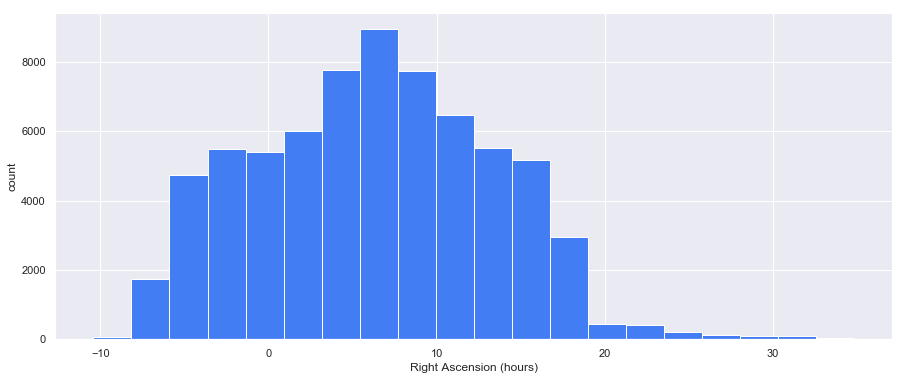

In [307]:
plt.figure(figsize = (15, 6))
plt.hist(RA, bins = 20, color = "#427df4")
plt.ylabel("count")
plt.xlabel("Right Ascension (hours)")
plt.show()

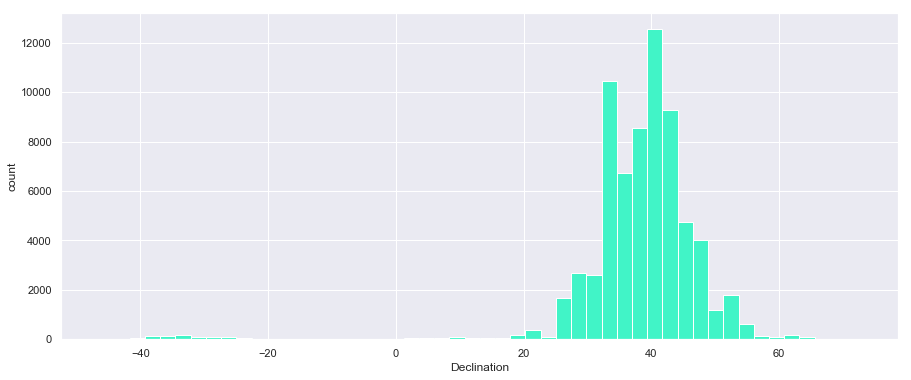

In [296]:
plt.figure(figsize = (15, 6))
plt.hist(dec, bins = 50, color = "#41f4c7")
plt.xlabel("Declination")
plt.ylabel("count")
plt.show()

## K-means Clustering

In [263]:
X = []
for i in range(len(RA)): 
    coordinate = (RA[i], dec[i])
    X.append(coordinate)
X = array(X)

In [153]:
number_of_clusters = range(1,20)
kmeans = [KMeans(n_clusters = i) for i in number_of_clusters]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]

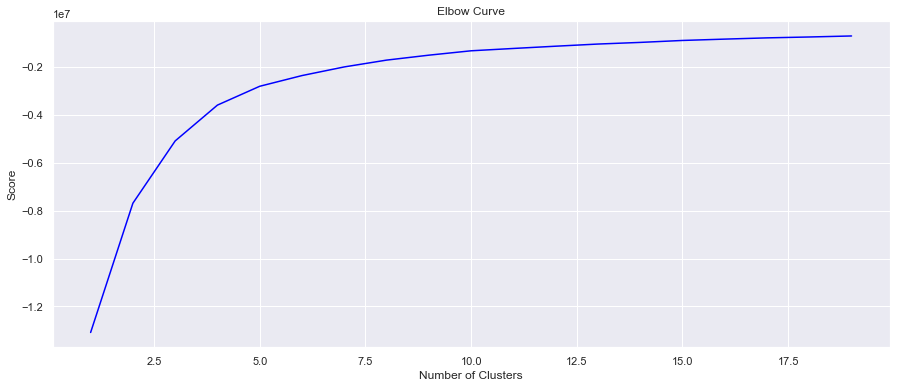

In [262]:
plt.figure(figsize = (15, 6))
plt.plot(number_of_clusters, score, color = "blue")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.title("Elbow Curve")
plt.show()

Choose around 6 or 7 clusters. 

In [309]:
#Kmeans clustering with 6 clusters. 
kmeans6 = KMeans(n_clusters = 7) 
kmeans6.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [311]:
print("Cluster centroids")
print("----------------------------")
print(kmeans6.cluster_centers_)

Cluster centroids
----------------------------
[[ 17.70227399  31.70330706]
 [ 12.58542816  50.98864852]
 [ 11.92146019 -30.19091644]
 [  5.67601485  31.99552567]
 [ 11.93077261  40.66546045]
 [  3.87740437  42.14928487]
 [ 19.97292832  41.53003883]]


In [ ]:
#pinwheel galaxy, maywell object, sunflower galaxy, whirlpool galaxy

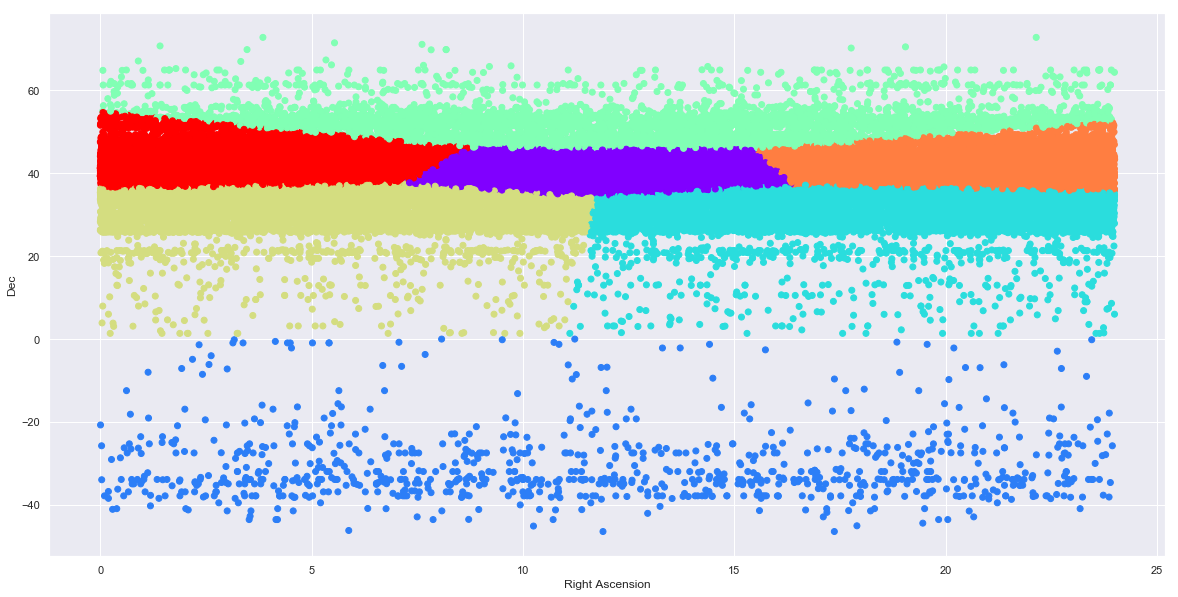

In [300]:
plt.figure(figsize = (20, 10))
plt.scatter(X[:,0], X[:,1], c = kmeans6.labels_, cmap = "rainbow")
plt.xlabel("Right Ascension")
plt.ylabel("Dec")
plt.show()